In [1]:
!pip install --upgrade pip
!pip install imutils
!pip install opencv-python
!pip install --upgrade scikit-learn==0.23.0

  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'C:\\Users\\EDIKKE~1\\AppData\\Local\\Temp\\pip-uninstall-mmdhkb4h\\pip.exe'
Consider using the `--user` option or check the permissions.



  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [2]:
# Подключение базовых библиотек для обработки изображений
from IPython.display import Image
from imutils import paths
import numpy as np
import cv2
import os

In [3]:
# Для работы с изображениями, найдем их гистограммы — характеристики распределения интенсивности изображения.
# Для этого можно воспользоваться следующим методом.
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [4]:
# Считаем изображения из корневой папки train и вычислим гистограмму каждого изображения.
# Кроме того, отделим метку каждого изображения.
# Обработка большого числа изображений в облачных сервисах занимает длительное время (1-5 минут).
imagePaths = sorted(list(paths.list_images('train')))
trainData = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = extract_histogram(image)
    trainData.append(hist)
    labels.append(label)

In [5]:
# Преобразуем метки в удобный формат 0 и 1. Cat заменяем на 1, Dog на 0.
Y = [1 if x == 'cat' else 0 for x in labels]

1


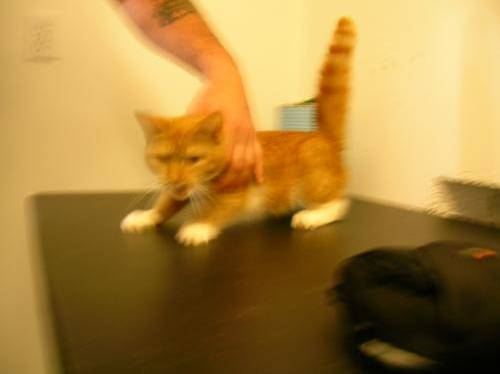

In [6]:
print(Y[0])
Image(filename=imagePaths[0])

In [7]:
# Видно, что классом 1 у нас занумерованы коты (кошки).

# Обучаем первый базовый классификатор - бэггинг деревьев принятия решений
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=92)
bagging = BaggingClassifier(tree, #базовый алгоритм
                            n_estimators=20, #количество деревьев
                            random_state=92)
bagging.fit(trainData, Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_leaf_nodes=20,
                                                        min_samples_leaf=10,
                                                        random_state=92),
                  n_estimators=20, random_state=92)

In [8]:
# Теперь обучим модель почти-разделяющий гиперплосоксти.
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state = 92, C = 1.92)
svm.fit(trainData, Y)

LinearSVC(C=1.92, random_state=92)

In [9]:
# И наконец обучаем третий базовый алгоритм — случайный лес
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=20, #количество деревьев
                             criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=92)
forest.fit(trainData, Y)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=20,
                       min_samples_leaf=10, n_estimators=20, random_state=92)

In [10]:
# Задаем в качестве решающего метаалгоритма логистическую регрессию:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', random_state=92)

In [11]:
# Обучаем метаалгоритм
from sklearn.ensemble import StackingClassifier

base_estimators = [('SVM', svm), ('Bagging DT', bagging), ('DecisionForest', forest)]
sclf = StackingClassifier(estimators=base_estimators, final_estimator=lr, cv=2)
sclf.fit(trainData, Y)

StackingClassifier(cv=2,
                   estimators=[('SVM', LinearSVC(C=1.92, random_state=92)),
                               ('Bagging DT',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                        max_leaf_nodes=20,
                                                                                        min_samples_leaf=10,
                                                                                        random_state=92),
                                                  n_estimators=20,
                                                  random_state=92)),
                               ('DecisionForest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_leaf_nodes=20,
                                                       min_samples_leaf=10,
          

In [13]:
# Оценка метамодели. Доля правильной классификации (Accuracy):
sclf.score(trainData, Y)

0.849

In [18]:
# Вычислим предсказания для объекта из папки test
singleImage = cv2.imread('test/dog.1005.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
prediction = sclf.predict(histt2)

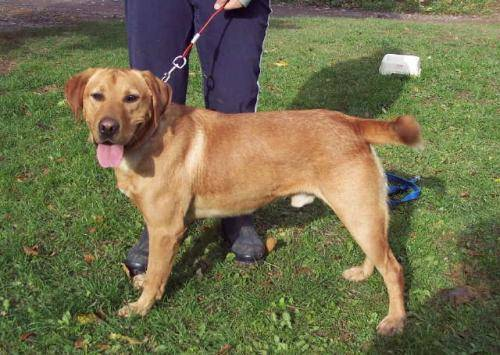

In [19]:
Image(filename='test/dog.1005.jpg')

In [20]:
prediction

array([0])

In [21]:
sclf.predict_proba(histt2)

array([[0.90373628, 0.09626372]])

In [ ]:
# Видно, что построенный классификатор успешно справился с заданием.